In [47]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('/home/franco/scripts')
import rmol_tools as rmt
import pumpprobe_tools as ppt

## Analysis of molecular orbital population as a function of energy and time

### System: Ag55 NP, pulse lenght = 100 fs, pulse peak intensity = 0.01 V/Ang, sin^2 shape

In [28]:
FIELD=0.01
PULSE_LENGTH =100
ROOTDIR = '/home/franco/results/55/pumpprobe/pulses'
WORKDIR=ROOTDIR+str(PULSE_LENGTH)+'/test/'
TESTDIR=WORKDIR
RHOMOLDIR=ROOTDIR+str(PULSE_LENGTH)+'/'

In [9]:
names, coords = rmt.readCoords(WORKDIR+'coords.xyz')
evals, evecs = rmt.getEnergies(TESTDIR, names, coords)
np.savetxt(WORKDIR+'evals.dat',np.transpose(evals))

In [19]:
time, rmol = rmt.getRhomol(RHOMOLDIR+'rhomol.dat')

Number of orbitals calculated = 495
Number of steps calculated = 1000


In [20]:
nbins = 100
maxdh, mindh = max(evals), min(evals)
bins = np.linspace(mindh, maxdh, nbins)
steps = 1000
saveevery = 1
populs = []
for step in range(steps):
    populs.append(rmt.getHist(rmol, bins, step*saveevery, evals))
populs = np.array(populs)

In [22]:
maxval = max(abs(populs.max()),abs(populs.min()))

In [25]:
gamma = 0.05
energies = np.linspace(evals.min(), evals.max(), 1000)
dos = rmt.getDOS(energies, evals, gamma)

In [111]:
import matplotlib
matplotlib.rcParams['font.size'] = 20

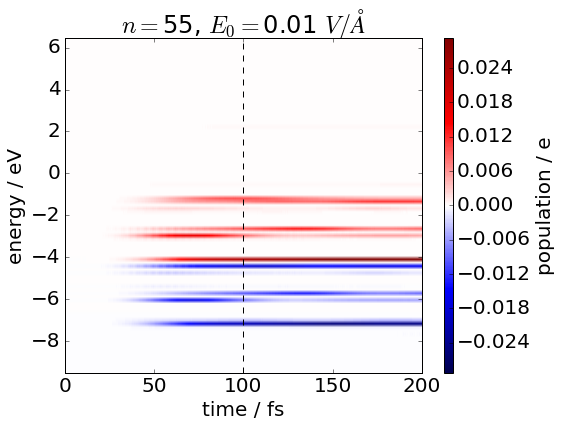

In [33]:
plt.figure(figsize=(8,6))
plt.imshow(populs.T, aspect='auto', cmap='seismic', vmax=maxval, vmin=-maxval, \
          extent=[0, time[steps*saveevery-1], evals[0], evals[-1]], origin='lower')
cbar = plt.colorbar(aspect=40)
cbar.set_label('population / e',fontsize=20)
plt.title('$n= $'+str(55)+', $E_0=$'+str(FIELD)+' $V/\AA$')
#plt.ylim(-6,6)
plt.xlim(0,200)
plt.xlabel('time / fs')
plt.ylabel('energy / eV')
plt.axvline(PULSE_LENGTH,linestyle='--',color='k')
#plt.axhline(fermi, lw=3,color='k')
#plt.annotate('Fermi level', xy=(1.,fermi+0.2), color='k')
#plt.savefig(outdir+'309-0.25-rhomolbyenergy.png', dpi=300)

Orbital population looks nice, since only orbitals close to the Fermi level are populated.

### Analysis of probe spectra

In [37]:
pumped_mu = np.genfromtxt(RHOMOLDIR+'mu.dat')
pu_mux = pumped_mu[:,1]
pu_muy = pumped_mu[:,2]
pu_muz = pumped_mu[:,3]
pu_time = pumped_mu[:,0]

In [42]:
!grep Nsteps $RHOMOLDIR'dftb_in.hsd'

      Nsteps = 416000


In [45]:
nsteps = 416000
ndump = int(nsteps/50)

nframes = 10

In [49]:
linesall = []

for frame in range(nframes):
    os.chdir(RHOMOLDIR+'frame'+str(frame)+'/')
    with open('muz.dat', 'r') as muz:
        lines=len(muz.readlines())
        linesall.append(lines)
shortest = min(linesall)
print(shortest)

20000


In [76]:
import imp
imp.reload(ppt)

<module 'pumpprobe_tools' from '/home/franco/scripts/pumpprobe_tools.py'>

In [105]:
frame = 0
os.chdir(RHOMOLDIR+'frame'+str(frame)+'/')
pr_time, mux, muy, muz = ppt.loaddata(shortest)

pr_mux = mux - pu_mux[:mux.shape[0]]
pr_muy = muy - pu_muy[:muy.shape[0]]
pr_muz = muz - pu_muz[:muz.shape[0]]

avemu = (mux-mux[0]+muy-muy[0]+muz-muz[0])/3.
substed_avemu = (pr_mux-pr_mux[0]+pr_muy-pr_muy[0]+pr_muz-pr_muz[0])/3.


freq, imag_spec = ppt.fft(avemu, pr_time, 10, res='imag')
freq, power_spec = ppt.fft(substed_avemu, pr_time, 10, res='power')
plasmon0 = ppt.find_peak(freq, spec)

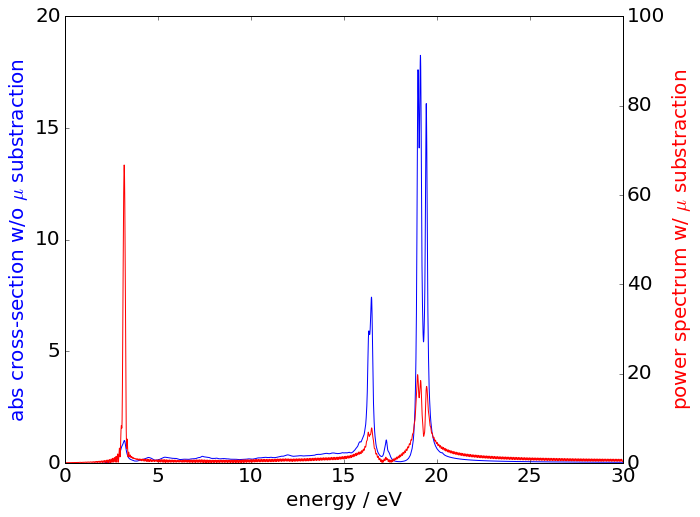

In [121]:
fig, ax1 = plt.subplots(figsize=(10,8))
ax1.plot(freq,imag_spec,label='abs cross-section w/o $\mu$ substraction')
ax2 = ax1.twinx()
ax2.plot(freq,power_spec,color='red',label='power spectrum w/ $\mu$ substraction')
ymin = 0
ymax1 = 20
ymax2 = 100
ax1.set_ylim(ymin,ymax1)
ax2.set_ylim(ymin,ymax2)
ax1.set_ylabel('abs cross-section w/o $\mu$ substraction')
ax2.set_ylabel('power spectrum w/ $\mu$ substraction')
ax1.set_xlabel('energy / eV')
ax1.yaxis.label.set_color('blue')
ax2.yaxis.label.set_color('red')

In [62]:
#possible range of plasmon: between 2 and 4 eV
ini_plsm_idx = np.argmin(abs(freq-2.))
end_plsm_idx = np.argmin(abs(freq-4.))

In [81]:
np_spec = spec.shape[0]
plsm_idx = np.argmin(abs(spec-plasmon0))
maxframes = 9
spectra = np.zeros((maxframes,np_spec))

In [89]:
for frame in range(maxframes):
    os.chdir(RHOMOLDIR+'frame'+str(frame)+'/')
    pr_time, mux, muy, muz = ppt.loaddata(shortest)
    
    pr_mux = mux - pu_mux[frame*ndump:frame*ndump+shortest]
    pr_muy = muy - pu_muy[frame*ndump:frame*ndump+shortest]
    pr_muz = muz - pu_muz[frame*ndump:frame*ndump+shortest]
    
    avemu = (pr_mux-pr_mux[0]+pr_muy-pr_muy[0]+pr_muz-pr_muz[0])/3.
    freq, spec = ppt.fft(avemu, pr_time, 10)
    
    spectra[frame,:] = spec

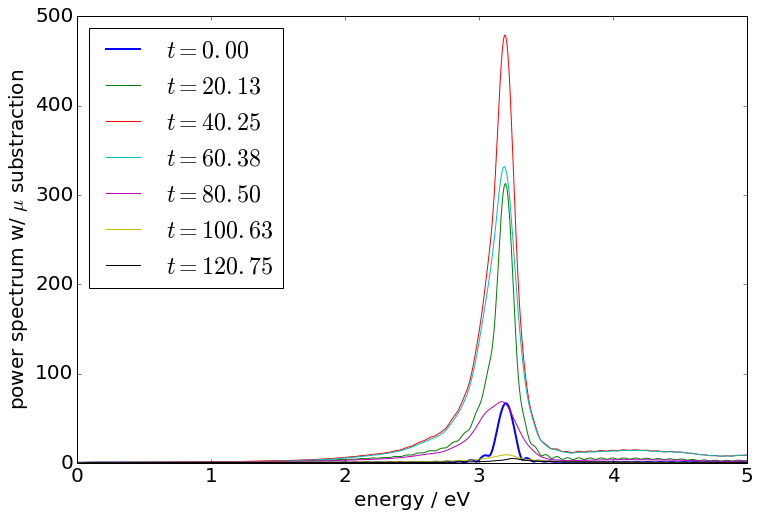

In [123]:
plt.figure(figsize=(12,8))
plt.plot(freq,spectra[0,:],lw=2,label='$t={:.2f}$'.format(pu_time[0*ndump]))
for frame in range(1,7):
    plt.plot(freq,spectra[frame,:],lw=1,label='$t={:.2f}$'.format(pu_time[frame*ndump]))
plt.xlim(0,5)
plt.legend(loc='upper left')
plt.xlabel('energy / eV')
plt.ylabel('power spectrum w/ $\mu$ substraction')

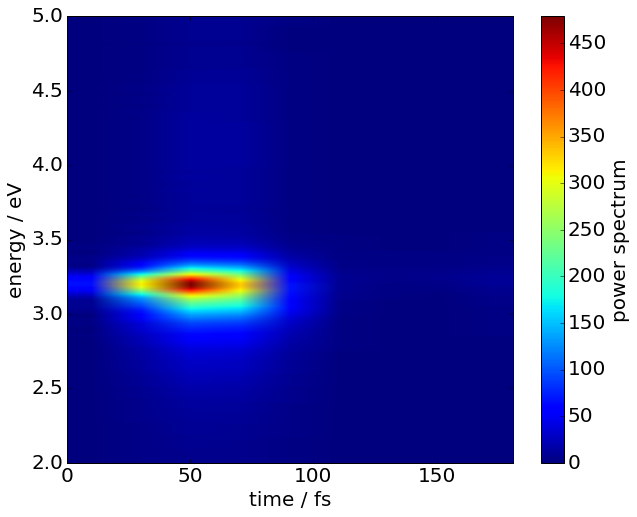

In [126]:
vmax = spectra.max()
tmax = pu_time[maxframes*ndump]
plt.figure(figsize=(10,8))
plt.imshow(spectra[:maxframes,:].T, aspect='auto', origin='low',extent=[0,tmax,freq.min(),freq.max()])
plt.ylim(2,5)
plt.xlabel('time / fs')
plt.ylabel('energy / eV')
cbar = plt.colorbar()
cbar.set_label('power spectrum')

In [128]:
intens_at_plsm = []
for frame in range(maxframes):
    intens_at_plsm.append(spectra[frame,plsm_idx])

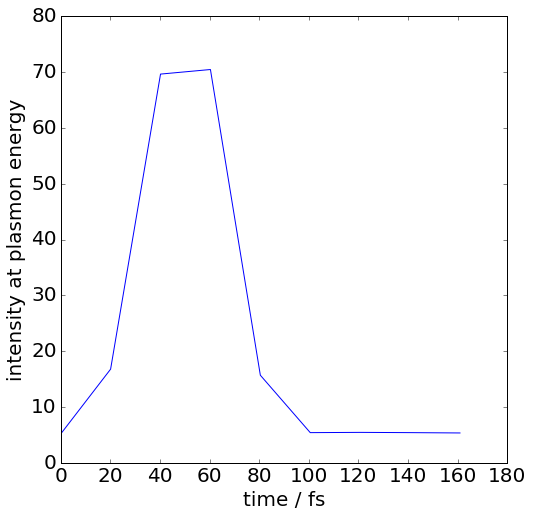

In [130]:
fig, ax = plt.subplots(figsize=(8,8))
plt.plot(pu_time[0:maxframes*ndump:ndump],intens_at_plsm)
plt.ylabel('intensity at plasmon energy')
plt.xlabel('time / fs')